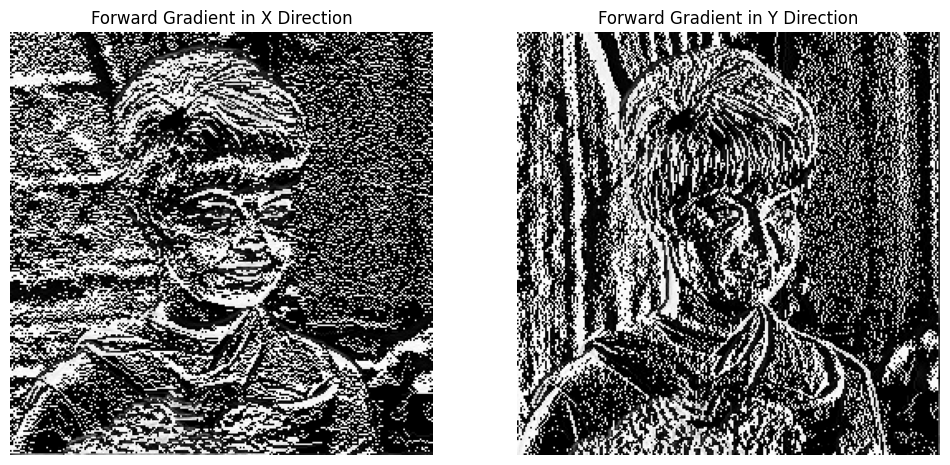

In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from MCV2.poisson_editing import *

image = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/lena/girl.png', cv2.IMREAD_GRAYSCALE)
grad_i,grad_j = im_fwd_gradient(image)
# Display the gradients
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Forward Gradient in X Direction')
plt.imshow(grad_i,cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Forward Gradient in Y Direction')
plt.imshow(grad_j,cmap='gray')
plt.axis('off')

plt.show()

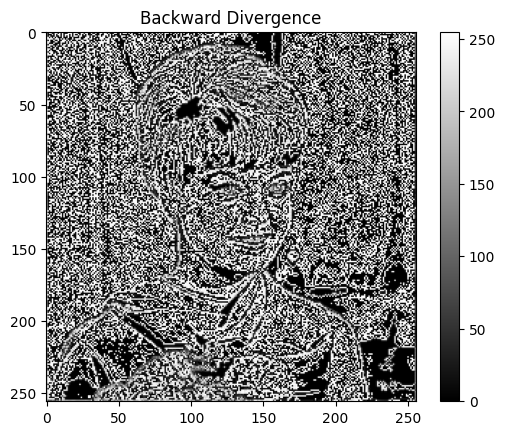

In [58]:
# Calculate the backward divergence
divergence = im_bwd_divergence(grad_i, grad_j)

# Display the divergence
plt.imshow(divergence, cmap='gray')
plt.colorbar()
plt.title('Backward Divergence')
plt.show()

In [68]:
src = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/monalisa/ginevra.png',cv2.IMREAD_COLOR)
dst = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/monalisa/lisa.png',cv2.IMREAD_COLOR)
original_height, original_width = src.shape[:2]
src = cv2.resize(src, (256, 256))
dst = cv2.resize(dst, (256, 256))
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
print(src.shape,dst.shape)

(256, 256, 3) (256, 256, 3)


(256, 256)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


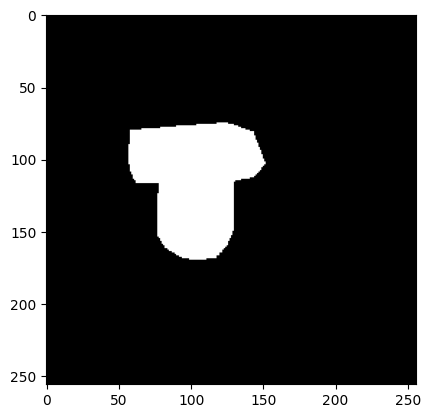

In [60]:
original_mask = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/monalisa/mask.png',cv2.IMREAD_GRAYSCALE)  # Replace with actual original mask
translated_mask = cv2.imread('C:/Users/laila/Downloads/CV2425_project_week22/CV2425_project_week2/images/monalisa/mask.png',cv2.IMREAD_GRAYSCALE)   # Replace with actual translated mask
original_mask = cv2.resize(original_mask, (256, 256))
translated_mask = cv2.resize(translated_mask, (256, 256))
#offset = get_translation(original_mask, translated_mask)
converted_mask = np.where(translated_mask >= 1, 1, translated_mask)
print(converted_mask.shape)
print(translated_mask == 255)
plt.imshow(converted_mask,cmap='gray')

In [61]:
y_max, x_max = dst.shape[:-1]
y_min, x_min = 0, 0
x_range = x_max - x_min
y_range = y_max - y_min
offset=(24,8)
M = np.float32([[1, 0, offset[1]], [0, 1, offset[0]]])
source = cv2.warpAffine(src, M, (x_range, y_range))
translated_image=source
print(translated_image.shape)

(256, 256, 3)


In [62]:
translated_image=src

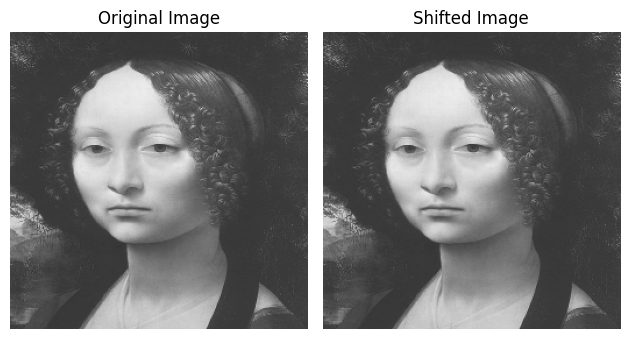

In [63]:
# Plotting the original and shifted images

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(src)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Shifted Image")
plt.imshow(translated_image,cmap='brg')
plt.axis('off')

plt.tight_layout()
plt.show()

(256, 256, 3)


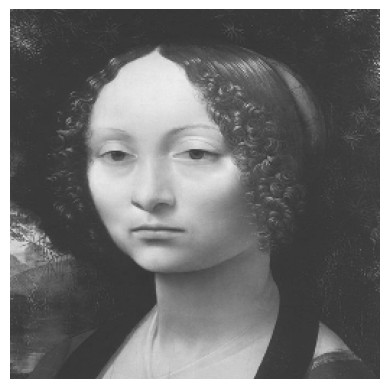

(256, 256, 3)


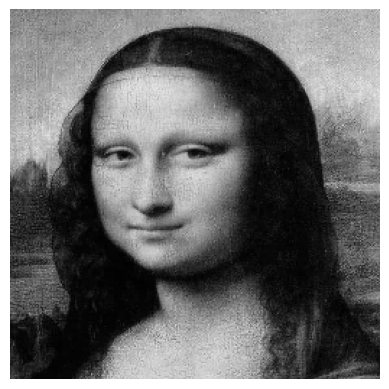

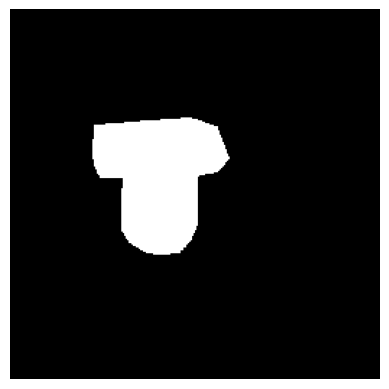

In [64]:
# Define the cropping box (y1:y2, x1:x2)
crop_box = translated_image#[100:300, 100:300]  # Adjust these values as needed

print(crop_box.shape)
# Plot the cropped image
plt.imshow(crop_box)
plt.axis('off')  # Hide the axes
plt.show()

#####################################################################################
#Crop the target image too 
# Define the cropping box (y1:y2, x1:x2)
crop_box_dst = dst#[100:300, 100:300] # Adjust these values as needed

print(crop_box_dst.shape)
# Plot the cropped image
plt.imshow(crop_box_dst)
plt.axis('off')  # Hide the axes
plt.show()
#################################################################################
#Crop the mask 
crop_box_mask = converted_mask#[100:300, 100:300]  # Adjust these values as needed
plt.imshow(converted_mask,cmap='gray')
plt.axis('off')  # Hide the axes
plt.show()

In [65]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Flatten the source and target images

combined_image = np.zeros_like(crop_box_dst)


for channel in range(3):
    combined_image[:, :, channel] = converted_mask * crop_box[:, :, channel] + (1 - converted_mask) * crop_box_dst[:, :, channel]
    m = converted_mask
    u = combined_image[:, :, channel]
    f = crop_box_dst[:, :, channel]
    u1 = crop_box[:, :, channel]
    source_flat = u1.flatten()
    target_flat = f.flatten()
    mask_flat = m.flatten()
    # Initialize combined image


    # Calculate beta based on the mask
    beta_0 = 1
    beta = beta_0 * (1 - m)

    # Extract dimensions
    original_u_shape = u.shape
    y_min, y_max = 0, original_u_shape[0]
    x_min, x_max = 0, original_u_shape[1]

    # Precompute gradients and divergence
    vi, vj = composite_gradients(u1, f, m)
    div = im_bwd_divergence(vi, vj)

    # Compute b vector only once
    Bu2 = beta * f
    b = Bu2 - div

    # Define the quadratic energy function
    def E(u):
        u_reshaped = u.reshape(original_u_shape)
        gradients = poisson_linear_operator(u_reshaped, beta)
        energy = (0.5 * np.dot(gradients.flatten(), u) - np.dot(b.flatten(), u) +
                0.5 * np.dot(vi.flatten(), vj.flatten()) +  
                0.5 * np.dot(Bu2.flatten(), target_flat))
        return energy


    # Perform the optimization 
    result = minimize(E, u.flatten(), method='CG', 
                    options={'maxiter': 3, 'disp': True})

    # Reshape the result back to original dimensions if needed
    optimized_image = result.x.reshape(original_u_shape)
    combined_image[:, :, channel] = optimized_image

final = combined_image



C:\Users\laila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_minimize.py:724: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 77509890.842890
         Iterations: 3
         Function evaluations: 720907
         Gradient evaluations: 11
         Current function value: 77509890.842890
         Iterations: 3
         Function evaluations: 720907
         Gradient evaluations: 11
         Current function value: 77509890.842890
         Iterations: 3
         Function evaluations: 720907
         Gradient evaluations: 11


In [87]:
x = np.zeros_like(crop_box_dst)
for channel in range(3):
    x[:, :, channel] = converted_mask * crop_box[:, :, channel] + (1 - converted_mask) * crop_box_dst[:, :, channel]

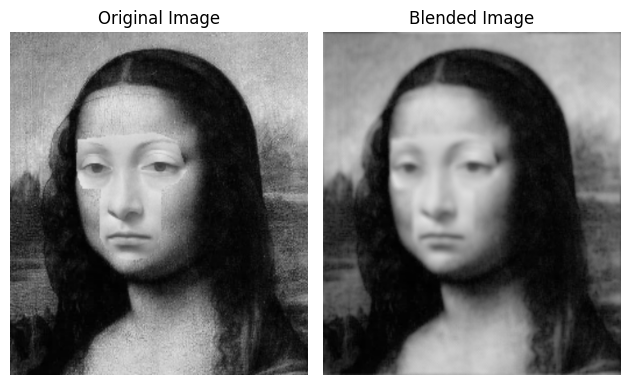

In [89]:
    # Display the resulting grayscale image
plt.subplot(1, 2, 1)
plt.title("Original Image")
x = cv2.resize(x, (original_width, original_height))
plt.imshow(x)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Blended Image")
final = cv2.resize(combined_image, (original_width, original_height))
plt.imshow(final,cmap='brg')
plt.axis('off')

plt.tight_layout()
plt.show()



In [11]:
import numpy as np
from scipy.optimize import minimize

# Initialize combined image
u_comb = np.zeros_like(crop_box_dst)  # Combined image
m = crop_box_mask

# Extract dimensions
y_max, x_max = crop_box_dst.shape[:-1]
y_min, x_min = 0, 0

def E(u, A, b, c):

    """Calculate the energy value."""
    u = np.array(u)
    energy_value = 0.5 * np.dot(u, A @ u) - np.dot(b, u) + c.item() # Ensure c is a scalar
    return energy_value  # Ensure it's a scalar

# Assuming mask, u_comb, dst, src, and poisson_editing are defined
final_result = np.zeros_like(u_comb)

# Iterate over each color channel
for channel in range(3):
    u = u_comb[:, :, channel]
    u2 = crop_box_dst[:, :, channel]
    u1 = crop_box[:, :, channel]
    plt.imshow(u)

    plt.show()
    plt.imshow(u1)
    plt.show()
    plt.imshow(u2)
    plt.show()
    beta_0 = 1
    beta = beta_0 * (1 - m)

    # Compute gradients and matrices
    vi, vj = compute_composite_gradient(u1, u2, m)
    A = poisson_linear_operator(u, beta)
    
    # Now create b
    b = (beta * u2) - im_bwd_divergence(vi, vj)

    v = np.array([vi, vj])
    c = 0.5 * np.sum(v ** 2) + 0.5 * np.sum(beta * u2 ** 2)

    shape = u.shape

    # Optimize using L-BFGS-B
    result = minimize(E, u.flatten(), args=(A, b.flatten(), c), method='L-BFGS-B')

    # Reshape to original dimensions and store the result
    optimal_u = result.x.reshape(shape)
    u_comb[:, :, channel] = optimal_u

# Final combined result
u_final = u_comb


ValueError: not enough values to unpack (expected 2, got 1)

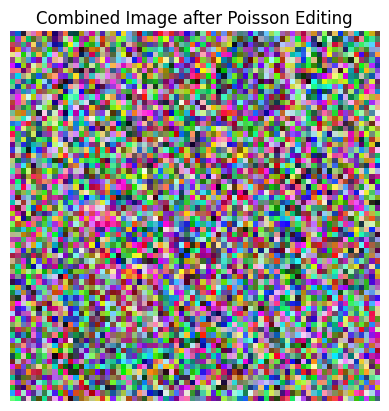

In [16]:
# Plotting
plt.imshow(u_comb)  # Use imshow to display the image
plt.axis('off')  # Turn off axis
plt.title("Combined Image after Poisson Editing")
plt.show()